In [3]:
# Se obtienen los archivos necesarios de drive para que funcione bien el código y no tener que importarlos cada vez que se requiera su uso
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the data files from drive
hospital1 = '/content/drive/MyDrive/Data Processes/hospital1.xlsx'
hospital2 = '/content/drive/MyDrive/Data Processes/hospital2.xlsx'

In [5]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer, StandardScaler
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest

In [6]:
# Read the Excel files
df1 = pd.read_excel(hospital1)
df2 = pd.read_excel(hospital2)

# Combine the files into one
df = pd.concat([df1, df2], ignore_index=True)

# Save the result file
df.to_excel('hospital.xlsx', index=False)

In [7]:
# Display basic information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27449 entries, 0 to 27448
Data columns (total 59 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   patient ID                       14712 non-null  float64       
 1   patient ID.1                     14712 non-null  float64       
 2   nationality                      14712 non-null  object        
 3   age                              27446 non-null  float64       
 4   gender K=female E=male           14712 non-null  object        
 5   date_of_first_symptoms           27446 non-null  datetime64[ns]
 6   BASVURUTARIHI                    14712 non-null  datetime64[ns]
 7   fever_temperature                25759 non-null  float64       
 8   oxygen_saturation                27438 non-null  float64       
 9   history_of_fever                 27441 non-null  float64       
 10  cough                            27448 non-null  float64  

In [8]:
# Display basic information
print(df.head())

   patient ID  patient ID.1 nationality   age gender K=female E=male  \
0  11850006.0    11850006.0        T.C.  47.0                      K   
1   4373630.0     4373630.0        T.C.  23.0                      K   
2  12172023.0    12172023.0        T.C.  26.0                      K   
3  72856168.0    72856168.0        T.C.  60.0                      K   
4  72200559.0    72200559.0        T.C.  72.0                      K   

  date_of_first_symptoms BASVURUTARIHI  fever_temperature  oxygen_saturation  \
0             2022-01-01    2022-01-01               38.2               96.0   
1             2022-01-01    2022-01-01               37.0               96.0   
2             2022-01-01    2022-01-01               38.0               95.0   
3             2022-01-01    2022-01-01               36.5               95.0   
4             2021-12-22    2021-12-22               36.9               96.0   

   history_of_fever  ...  dementia  tuberculosis  smoking  other_risks  \
0           

In [9]:
# Merge 'patient ID' and 'patient_id' into a single column
df['patient ID'] = df['patient ID'].combine_first(df['patient_id'])

# Drop 'patient_id' and 'patient ID.1'
df.drop(columns=['patient_id', 'patient ID.1'], inplace=True)

In [10]:
# Drop 'admission_id', 'admission_date' and 'BASVURUTARIHI'
df.drop(columns=['admission_id', 'admission_date', 'BASVURUTARIHI'], inplace=True)

In [11]:
# Merge 'nationality' and 'country_of_residence' into a single column
df['nationality'] = df['nationality'].combine_first(df['country_of_residence'])

# Drop 'country_of_residence'
df.drop(columns=['country_of_residence'], inplace=True)

In [12]:
# Map gender codes
df['gender K=female E=male'] = df['gender K=female E=male'].map({'K': 'female', 'E': 'male'})

# Map gender codes
df['sex'] = df['sex'].map({'K': 'female', 'E': 'male'})

# Combine both columns
df['gender K=female E=male'] = df['gender K=female E=male'].combine_first(df['sex'])

# Drop 'sexe'
df.drop(columns=['sex'], inplace=True)

# Rename a single column
df.rename(columns={'gender K=female E=male': 'gender'}, inplace=True)

In [13]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27449 entries, 0 to 27448
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   patient ID                       27446 non-null  float64       
 1   nationality                      27446 non-null  object        
 2   age                              27446 non-null  float64       
 3   gender                           27445 non-null  object        
 4   date_of_first_symptoms           27446 non-null  datetime64[ns]
 5   fever_temperature                25759 non-null  float64       
 6   oxygen_saturation                27438 non-null  float64       
 7   history_of_fever                 27441 non-null  float64       
 8   cough                            27448 non-null  float64       
 9   sore_throat                      27448 non-null  float64       
 10  runny_nose                       27446 non-null  float64  

In [14]:
# Checking missing values for the dataset
missing_values = df.isnull().sum()
print(missing_values)

patient ID                            3
nationality                           3
age                                   3
gender                                4
date_of_first_symptoms                3
fever_temperature                  1690
oxygen_saturation                    11
history_of_fever                      8
cough                                 1
sore_throat                           1
runny_nose                            3
wheezing                              3
shortness_of_breath                   3
lower_chest_wall_indrawing            3
chest_pain                            3
conjunctivitis                        3
lymphadenopathy                       3
headache                              1
loss_of_smell                         1
loss_of_taste                         1
fatigue_malaise                       1
anorexia                              1
altered_consciousness_confusion       1
muscle_aches                          1
joint_pain                            1


In [15]:
# Separate columns into categorical and numerical
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Impute missing values in numerical columns with mean
num_imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# Impute missing values in categorical columns with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# Check if there are any remaining missing values
missing_values_after_imputation = df.isnull().sum()
print(missing_values_after_imputation)

patient ID                         0
nationality                        0
age                                0
gender                             0
date_of_first_symptoms             3
fever_temperature                  0
oxygen_saturation                  0
history_of_fever                   0
cough                              0
sore_throat                        0
runny_nose                         0
wheezing                           0
shortness_of_breath                0
lower_chest_wall_indrawing         0
chest_pain                         0
conjunctivitis                     0
lymphadenopathy                    0
headache                           0
loss_of_smell                      0
loss_of_taste                      0
fatigue_malaise                    0
anorexia                           0
altered_consciousness_confusion    0
muscle_aches                       0
joint_pain                         0
inability_to_walk                  0
abdominal_pain                     0
d

In [16]:
# Impute missing values with a default date, because simpleimputer gives problems when dealing with dates
df['date_of_first_symptoms'] = df['date_of_first_symptoms'].fillna(pd.to_datetime('2022-01-01'))

In [17]:
# Check if there are still missing values in the date_of_first_symptoms column
missing_dates = df['date_of_first_symptoms'].isnull().sum()
print(f"Missing values in the date column: {missing_dates}")

Missing values in the date column: 0


In [18]:
#Identify categorical columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Check unique values for each categorical column
for col in categorical_columns:
    unique_values = df[col].unique()
    print(f"Column: {col}")
    print(f"Number of unique values: {len(unique_values)}\n")

Column: nationality
Number of unique values: 111

Column: gender
Number of unique values: 2

Column: PCR_result
Number of unique values: 2



In [19]:
# Apply transformations to categorical columns
for col in df.select_dtypes(include=['object', 'category']).columns:
    unique_values = df[col].unique()

    if len(unique_values) == 2:
        # Apply Label Encoding (for binary categorical variables)
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    else:
        # Apply One-Hot Encoding (for multi-class categorical variables)
        df = pd.get_dummies(df, columns=[col], drop_first=True)  # drop_first=True to avoid multicollinearity

In [20]:
# View the transformed DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27449 entries, 0 to 27448
Columns: 161 entries, patient ID to nationality_Zimbabwe
dtypes: bool(110), datetime64[ns](1), float64(48), int64(2)
memory usage: 13.6 MB
None


In [21]:
# View the column names
print(df.columns[:60])

Index(['patient ID', 'age', 'gender', 'date_of_first_symptoms',
       'fever_temperature', 'oxygen_saturation', 'history_of_fever', 'cough',
       'sore_throat', 'runny_nose', 'wheezing', 'shortness_of_breath',
       'lower_chest_wall_indrawing', 'chest_pain', 'conjunctivitis',
       'lymphadenopathy', 'headache', 'loss_of_smell', 'loss_of_taste',
       'fatigue_malaise', 'anorexia', 'altered_consciousness_confusion',
       'muscle_aches', 'joint_pain', 'inability_to_walk', 'abdominal_pain',
       'diarrhoea', 'vomiting_nausea', 'skin_rash', 'bleeding',
       'other_symptoms', 'chronic_cardiac_disease', 'hypertension',
       'chronic_pulmonary_disease', 'asthma', 'chronic_kidney_disease',
       'obesity', 'liver_disease', 'asplenia', 'chronic_neurological_disorder',
       'malignant_neoplasm', 'chronic_hematologic_disease', 'AIDS_HIV',
       'diabetes_mellitus_type_1', 'diabetes_mellitus_type_2',
       'rheumatologic_disorder', 'dementia', 'tuberculosis', 'smoking',
      

In [22]:
# View the first few rows to check the label encoder and one-hot encoded columns
print(df[['gender', 'PCR_result', 'nationality_Turkmenistan', 'nationality_USA']].head())

   gender  PCR_result  nationality_Turkmenistan  nationality_USA
0       0           1                     False            False
1       0           1                     False            False
2       0           1                     False            False
3       0           1                     False            False
4       0           1                     False            False


In [23]:
# Move 'PCR_result' to the end as it is the target variable
cols = [col for col in df if col != 'PCR_result']  # Get all columns except 'PCR_result'
df = df[cols + ['PCR_result']]  # Append 'PCR_result' to the end

# Check the result
print(df.columns[-10:])  # Print the last 10 columns to verify

Index(['nationality_USA', 'nationality_Ukraine',
       'nationality_United Arab Emirates',
       'nationality_United Kingdom (Great Britain)', 'nationality_Uzbekistan',
       'nationality_Venezuela', 'nationality_Yemen', 'nationality_Zambia',
       'nationality_Zimbabwe', 'PCR_result'],
      dtype='object')


In [24]:
# Convert 'date_of_first_symptoms' to numeric: number of days from the minimum date
df['date_of_first_symptoms'] = (df['date_of_first_symptoms'] - df['date_of_first_symptoms'].min()).dt.days

# Separate features and target
X = df.drop(columns=['PCR_result'])
y = df['PCR_result']

# Select the top 40% of features based on mutual information
selector = SelectPercentile(mutual_info_classif, percentile=40)
X_selected = selector.fit_transform(X, y)

# Get the selected feature names (based on the boolean mask of selected features)
selected_features = X.columns[selector.get_support()]

# Print the selected features
print("Selected Features:", selected_features)

# Print the number of selected features
print("Number of Selected Features:", len(selected_features))

# Get X but only with the selected features as columns
X_feature_selection = X[selected_features]

Selected Features: Index(['patient ID', 'age', 'gender', 'date_of_first_symptoms',
       'fever_temperature', 'oxygen_saturation', 'history_of_fever', 'cough',
       'sore_throat', 'runny_nose', 'wheezing', 'headache', 'loss_of_taste',
       'fatigue_malaise', 'anorexia', 'muscle_aches', 'inability_to_walk',
       'obesity', 'chronic_hematologic_disease', 'rheumatologic_disorder',
       'tuberculosis', 'smoking', 'other_risks', 'nationality_Aland Islands',
       'nationality_Argentina', 'nationality_Armenia', 'nationality_Australia',
       'nationality_Belgium', 'nationality_Brazil',
       'nationality_British Indian Ocean Territory',
       'nationality_Brunei Darussalam', 'nationality_Bulgaria',
       'nationality_Colombia', 'nationality_Czech Republic',
       'nationality_CÃ”TE DIVOIRE (Ivory Coast)', 'nationality_El Salvador',
       'nationality_Ethiopia', 'nationality_France', 'nationality_Georgia',
       'nationality_Germany', 'nationality_Greece', 'nationality_India'

In [25]:
# Specify the features to discretize, only numerical ones will be used
numerical_features = X_feature_selection.select_dtypes(include=['float64', 'int64']).columns

# Initialize the KBinsDiscretizer
# n_bins is the number of bins you want to divide your data into
# encode='ordinal' means the bins will be labeled with integers (0, 1, 2,...)
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Apply the discretizer to the selected numerical features
X_feature_selection[numerical_features] = discretizer.fit_transform(X_feature_selection[numerical_features])

# View the discretized features
print(X_feature_selection[numerical_features].head())

   patient ID  age  gender  date_of_first_symptoms  fever_temperature  \
0         0.0  2.0     0.0                     4.0                3.0   
1         0.0  1.0     0.0                     4.0                2.0   
2         0.0  1.0     0.0                     4.0                3.0   
3         3.0  3.0     0.0                     4.0                1.0   
4         3.0  3.0     0.0                     3.0                1.0   

   oxygen_saturation  history_of_fever  cough  sore_throat  runny_nose  ...  \
0                4.0               0.0    0.0          0.0         0.0  ...   
1                4.0               4.0    0.0          4.0         0.0  ...   
2                4.0               4.0    4.0          0.0         0.0  ...   
3                4.0               0.0    0.0          0.0         0.0  ...   
4                4.0               0.0    0.0          0.0         0.0  ...   

   fatigue_malaise  anorexia  muscle_aches  inability_to_walk  obesity  \
0           

<ipython-input-25-9d47603da1df>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_feature_selection[numerical_features] = discretizer.fit_transform(X_feature_selection[numerical_features])


In [26]:
# Separate the numerical and non-numerical columns
numerical_columns = X_feature_selection.select_dtypes(include=['float64', 'int64']).columns
non_numerical_columns = X_feature_selection.select_dtypes(exclude=['float64', 'int64']).columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standardization to only the numerical columns
X_feature_selection_scaled = X_feature_selection.copy()  # Make a copy to avoid modifying the original
X_feature_selection_scaled[numerical_columns] = scaler.fit_transform(X_feature_selection[numerical_columns])

# The non-numerical columns are preserved as they are
# View the scaled features
print(X_feature_selection_scaled.head())

   patient ID       age    gender  date_of_first_symptoms  fever_temperature  \
0   -1.410104  0.323186 -0.849082                1.124934           1.289386   
1   -1.410104 -0.762765 -0.849082                1.124934           0.115627   
2   -1.410104 -0.762765 -0.849082                1.124934           1.289386   
3    0.711079  1.409138 -0.849082                1.124934          -1.058132   
4    0.711079  1.409138 -0.849082                0.399410          -1.058132   

   oxygen_saturation  history_of_fever     cough  sore_throat  runny_nose  \
0           0.114926         -0.988589 -0.642452    -0.668012   -0.426764   
1           0.114926          1.011837 -0.642452     1.497027   -0.426764   
2           0.114926          1.011837  1.556589    -0.668012   -0.426764   
3           0.114926         -0.988589 -0.642452    -0.668012   -0.426764   
4           0.114926         -0.988589 -0.642452    -0.668012   -0.426764   

   ...  nationality_Singapore  nationality_Slovakia (Slo

In [27]:
# Check class distribution in y, the target feature
print(y.value_counts())

PCR_result
1    23422
0     4027
Name: count, dtype: int64


In [28]:
# Calculate imbalance ratio
majority_class = y.value_counts().max()
minority_class = y.value_counts().min()
imbalance_ratio = majority_class / minority_class

print("Imbalance Ratio:", imbalance_ratio)

Imbalance Ratio: 5.816240377452198


<ipython-input-29-f6fc30f2f107>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


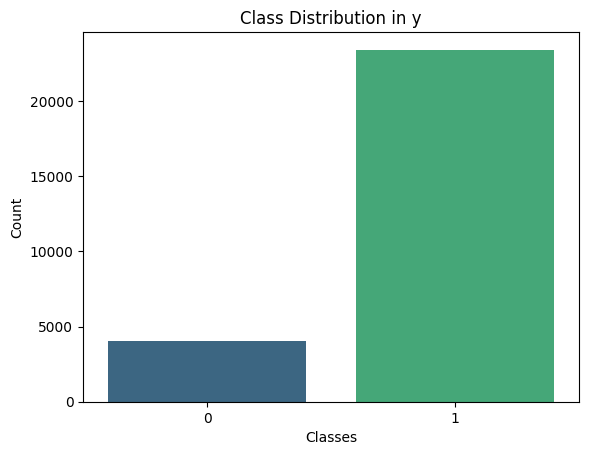

In [29]:
# Bar chart for class distribution
sns.countplot(x=y, palette='viridis')
plt.title("Class Distribution in y")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

In [30]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X_feature_selection_scaled, y)

# Check the new class distribution
print(y_resampled.value_counts())

PCR_result
1    23422
0    23422
Name: count, dtype: int64


In [31]:
# Combine X_feature_selection_scaled and y into a single DataFrame
final_df = pd.concat([X_resampled, y_resampled], axis=1)

# View the resulting DataFrame
print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46844 entries, 0 to 46843
Data columns (total 65 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   patient ID                                  46844 non-null  float64
 1   age                                         46844 non-null  float64
 2   gender                                      46844 non-null  float64
 3   date_of_first_symptoms                      46844 non-null  float64
 4   fever_temperature                           46844 non-null  float64
 5   oxygen_saturation                           46844 non-null  float64
 6   history_of_fever                            46844 non-null  float64
 7   cough                                       46844 non-null  float64
 8   sore_throat                                 46844 non-null  float64
 9   runny_nose                                  46844 non-null  float64
 10  wheezing  

In [32]:
# Save the DataFrame to an Excel file
final_df.to_excel('hospital_final.xlsx', index=False)

print("File saved as 'hospital_final.xlsx'")

File saved as 'hospital_final.xlsx'


In [33]:
# Extract numerical columns
numerical_columns = final_df.select_dtypes(include=['float64', 'int64']).columns
X_numerical = final_df[numerical_columns]

# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the model and predict outliers
outlier_labels = iso_forest.fit_predict(X_numerical)

# Add the outlier labels to the original dataframe
final_df['outlier'] = outlier_labels
final_df['outlier'] = final_df['outlier'].map({1: 'Normal', -1: 'Outlier'})

# Analyze results
print(final_df['outlier'].value_counts())  # Count of normal and outlier instances
print(final_df[final_df['outlier'] == 'Outlier'].head())  # View some detected outliers

outlier
Normal     44501
Outlier     2343
Name: count, dtype: int64
     patient ID       age    gender  date_of_first_symptoms  \
19     0.711079 -1.848717 -0.849082                1.124934   
73    -1.410104  0.323186  1.177742                1.124934   
90     0.004018  0.323186  1.177742                1.124934   
125   -1.410104 -0.762765 -0.849082                1.124934   
140    0.004018 -0.762765 -0.849082                1.124934   

     fever_temperature  oxygen_saturation  history_of_fever     cough  \
19            0.115627         -12.708635          1.011837  1.556589   
73            1.289386           0.114926         -0.988589 -0.642452   
90           -1.058132           0.114926          1.011837  1.556589   
125           1.289386           0.114926          1.011837  1.556589   
140           0.115627           0.114926          1.011837 -0.642452   

     sore_throat  runny_nose  ...  nationality_Syrian Arab Republic  \
19      1.497027   -0.426764  ...          

In [34]:
# Get only rows marked as 'Outlier'
outliers_only = final_df[final_df['outlier'] == 'Outlier']

# Calculate the counts of outliers for each numerical column
outlier_count = (outliers_only[numerical_columns] != 0).sum()

# Sort columns by count
columns_with_more_outliers = outlier_count.sort_values(ascending=False).index[:5]  # Top 5 by count

print("Columns with the most outliers:", columns_with_more_outliers)

Columns with the most outliers: Index(['patient ID', 'age', 'other_risks', 'smoking', 'tuberculosis'], dtype='object')


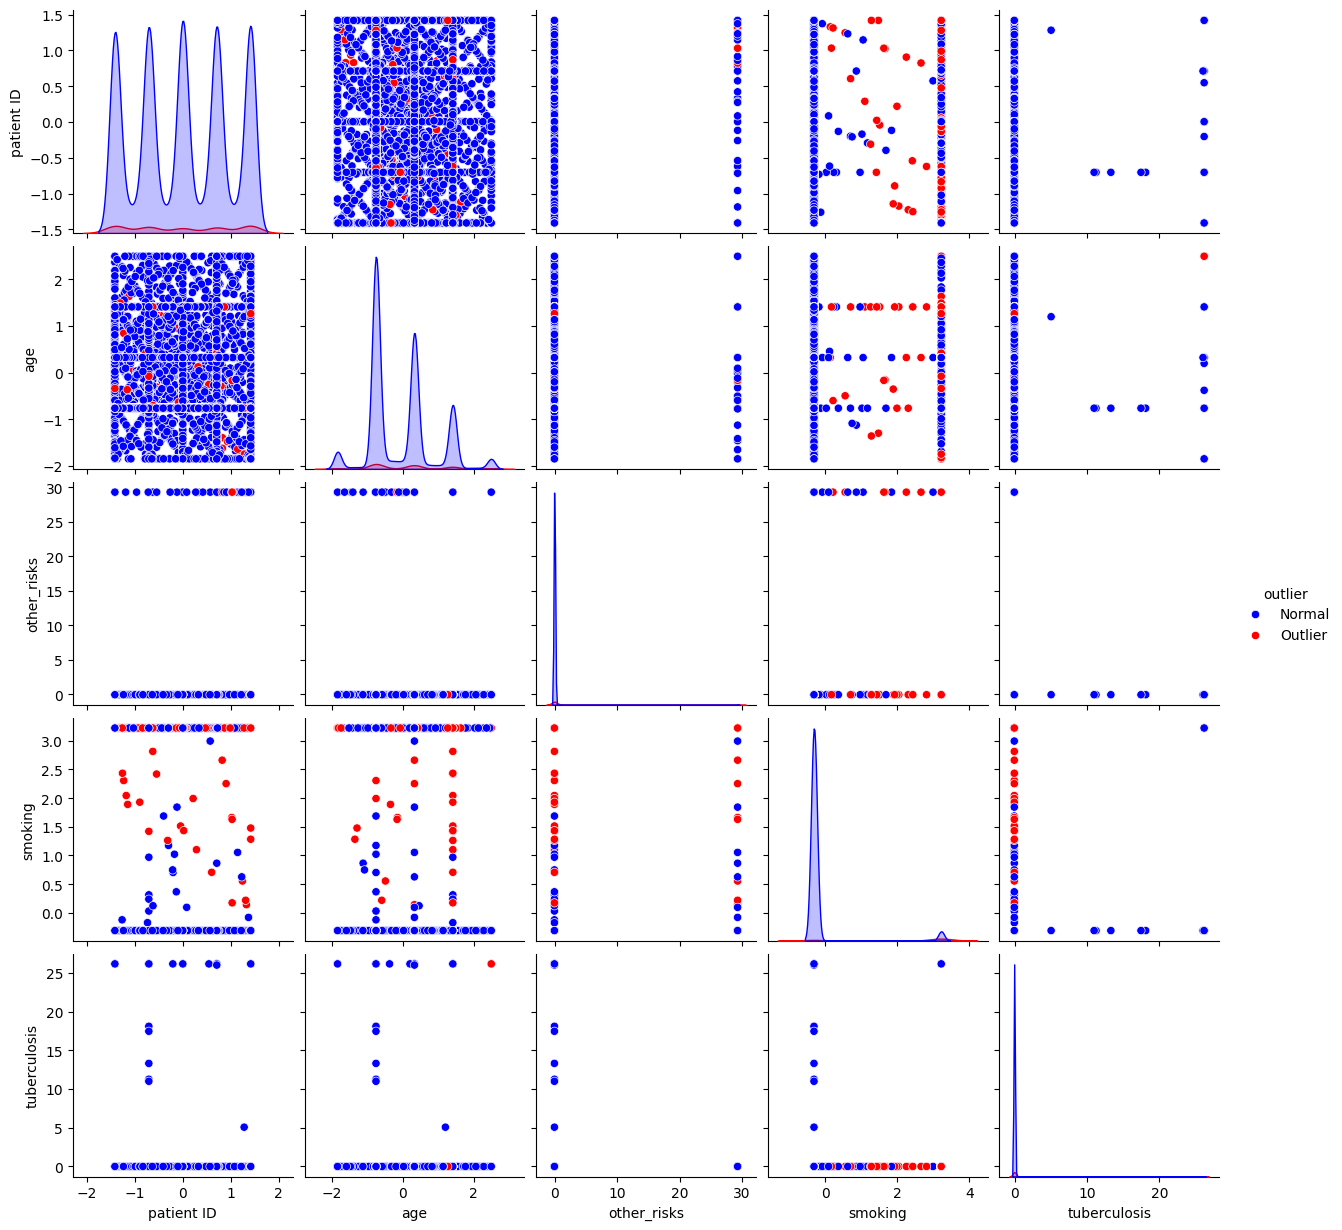

In [35]:
# Pair plot for the selected columns
sns.pairplot(final_df, vars=columns_with_more_outliers, hue='outlier', diag_kind='kde', palette={'Normal': 'blue', 'Outlier': 'red'})

## EDA

Summary of the variables and statistics for the numerical ones

In [36]:
import pandas as pd


data = final_df

# Print the summary of variables
print("Summary of Variables:")
print(f"Total rows: {data.shape[0]}")
print(f"Total columns: {data.shape[1]}")
print("\nVariable Names:")
for i, column in enumerate(data.columns):
    print(f"{i + 1}. {column}")

# Provide a brief statistical summary for numerical columns
print("\nStatistical Summary for Numerical Columns:")
print(data.describe())



Summary of Variables:
Total rows: 46844
Total columns: 66

Variable Names:
1. patient ID
2. age
3. gender
4. date_of_first_symptoms
5. fever_temperature
6. oxygen_saturation
7. history_of_fever
8. cough
9. sore_throat
10. runny_nose
11. wheezing
12. headache
13. loss_of_taste
14. fatigue_malaise
15. anorexia
16. muscle_aches
17. inability_to_walk
18. obesity
19. chronic_hematologic_disease
20. rheumatologic_disorder
21. tuberculosis
22. smoking
23. other_risks
24. nationality_Aland Islands
25. nationality_Argentina
26. nationality_Armenia
27. nationality_Australia
28. nationality_Belgium
29. nationality_Brazil
30. nationality_British Indian Ocean Territory
31. nationality_Brunei Darussalam
32. nationality_Bulgaria
33. nationality_Colombia
34. nationality_Czech Republic
35. nationality_CÃ”TE DIVOIRE (Ivory Coast)
36. nationality_El Salvador
37. nationality_Ethiopia
38. nationality_France
39. nationality_Georgia
40. nationality_Germany
41. nationality_Greece
42. nationality_India
43. nat

Show the proportion of nationalities in the study, excluding T.C.

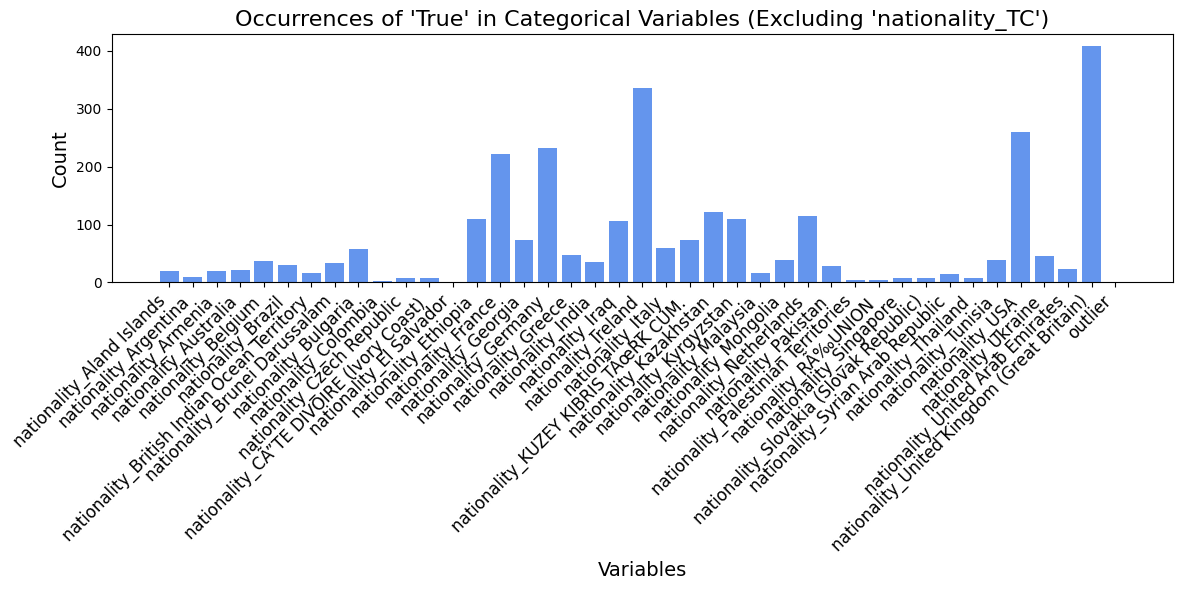

In [37]:
import matplotlib.pyplot as plt

# Select categorical columns excluding 'nationality_TC'
categorical_columns = data.select_dtypes(include=['object', 'bool']).columns
categorical_columns = [col for col in categorical_columns if col != 'nationality_T.C.']

# Count occurrences of True for each categorical column
true_counts = {}
for col in categorical_columns:
    true_counts[col] = data[col].apply(lambda x: str(x).lower() == 'true').sum()

# Plot the results as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(true_counts.keys(), true_counts.values(), color='cornflowerblue')
plt.title("Occurrences of 'True' in Categorical Variables (Excluding 'nationality_TC')", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Variables", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


Change the boolean nationalities to a factor of them

In [38]:
import pandas as pd

# Selecciona las columnas de nacionalidades
nationality_columns = [col for col in data.columns if col.startswith("nationality_")]

# Crea una nueva columna 'nationality' que verifica cuáles son True
data['nationality'] = data[nationality_columns].apply(
    lambda row: next((col.replace('nationality_', '') for col, val in row.items() if val), None),
    axis=1
)


# Create a new DataFrame without the nationality columns
data_without_nationalities = data.drop(columns=nationality_columns)

We can see a strong correlation between a few variables, such as headaches, shortness of breath of hypertension, while a lot of variables are almost no correlated with any of them

<Figure size 1500x1200 with 0 Axes>

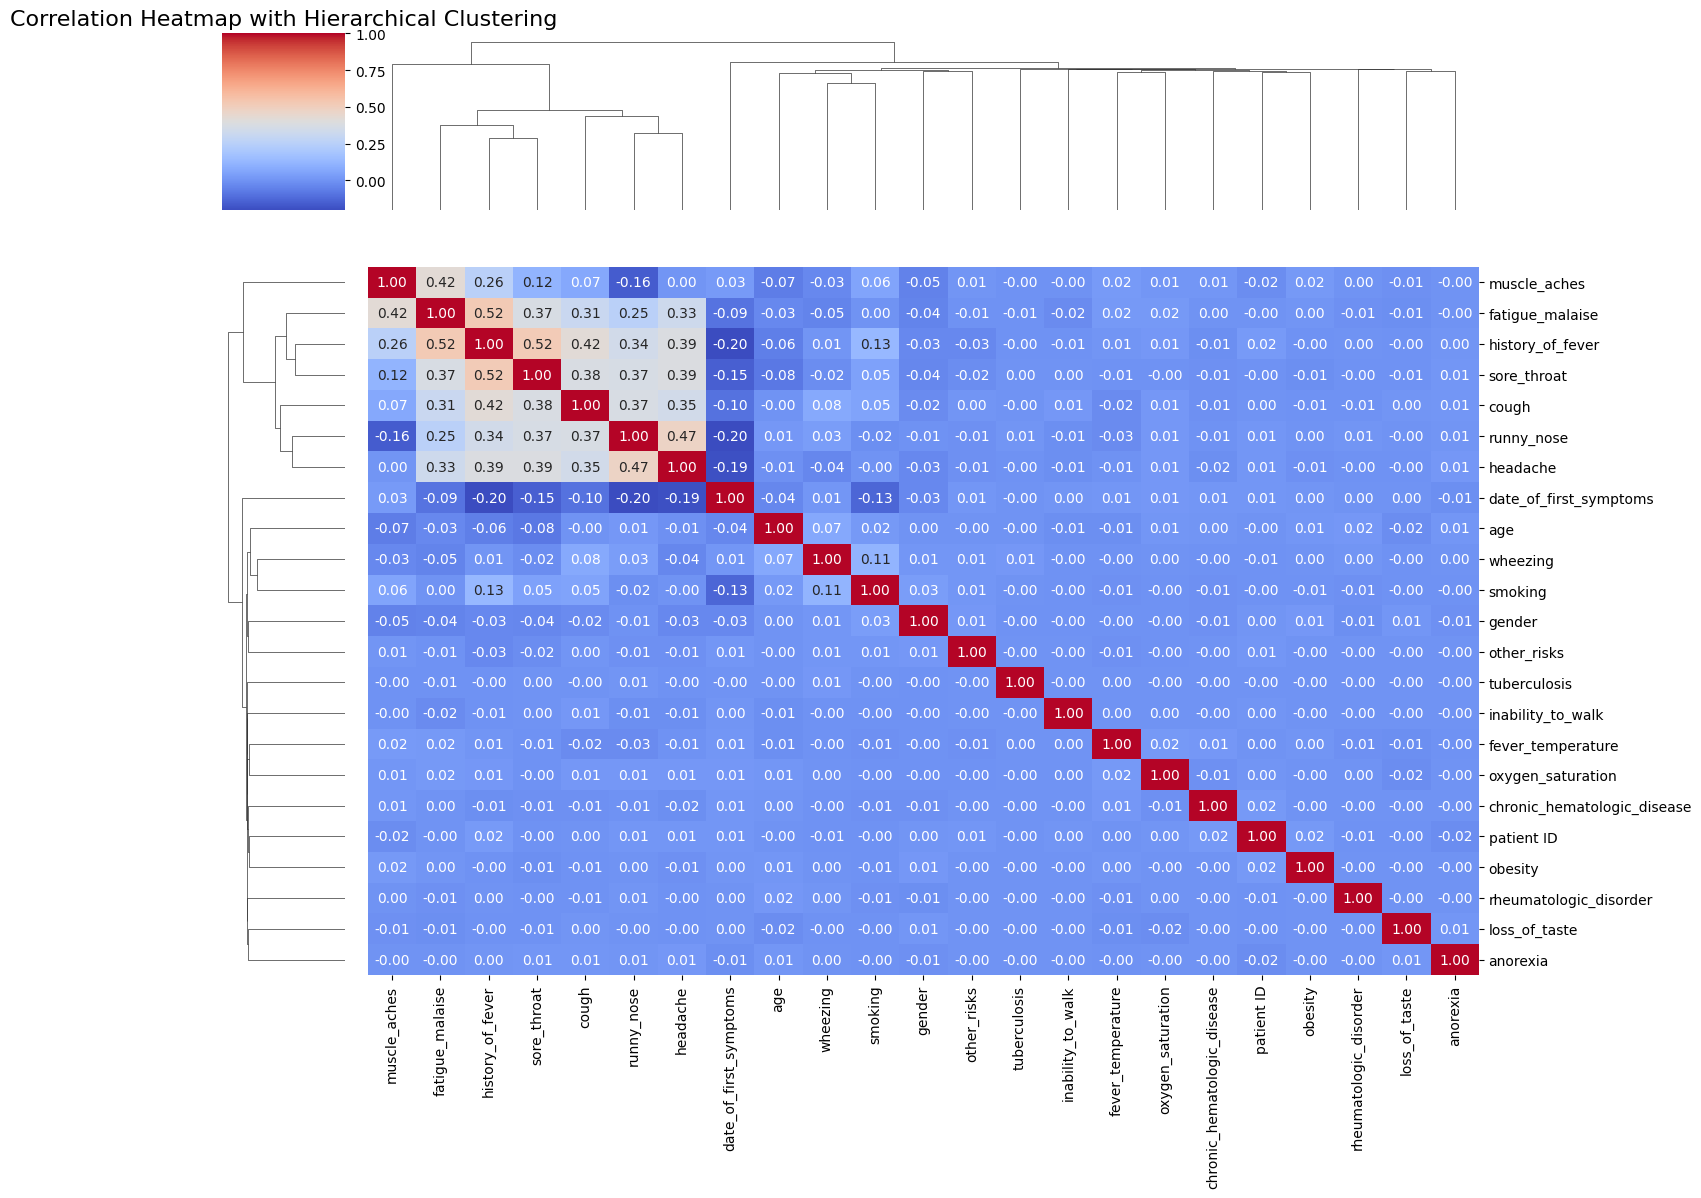

Chi-Square Test Results:
Chi-Square Statistic: 2120.998103617885
P-Value: 0.0
Degrees of Freedom: 40


<Figure size 1200x600 with 0 Axes>

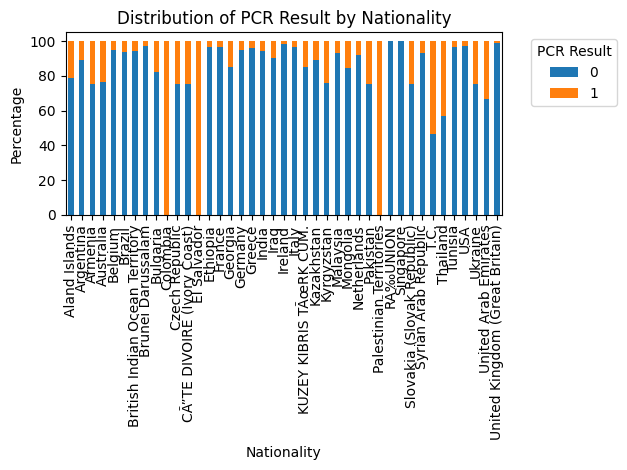

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# 1. Análisis de Correlación con Clustering Jerárquico
def correlation_clustering_analysis(data, target_column='PCR_result'):
    # Seleccionar solo variables numéricas excluyendo la target
    numeric_columns = data.select_dtypes(include=['number']).columns
    numeric_columns = [col for col in numeric_columns if col != target_column]
    numeric_data = data[numeric_columns]

    # Matriz de correlación
    correlation_matrix = numeric_data.corr()

    # Clustering jerárquico
    distance_matrix = 1 - correlation_matrix.abs()
    linkage_matrix = linkage(squareform(distance_matrix), method='ward')

    # Visualización del heatmap con clustering
    plt.figure(figsize=(15, 12))
    sns.clustermap(correlation_matrix,
                   cmap="coolwarm",
                   annot=True,
                   fmt=".2f",
                   figsize=(15, 12),
                   dendrogram_ratio=(.1, .2))
    plt.title("Correlation Heatmap with Hierarchical Clustering", fontsize=16)
    plt.tight_layout()
    plt.show()

    return correlation_matrix

# 2. Análisis Chi-Cuadrado por Nacionalidad
def chi_square_nationality_analysis(data, nationality_column='nationality', target_column='PCR_result'):
    # Crear tabla de contingencia
    contingency_table = pd.crosstab(data[nationality_column], data[target_column])

    # Realizar prueba chi-cuadrado
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print("Chi-Square Test Results:")
    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-Value: {p_value}")
    print(f"Degrees of Freedom: {dof}")

    # Visualización de la distribución
    plt.figure(figsize=(12, 6))
    contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
    contingency_table_percentage.plot(kind='bar', stacked=True)
    plt.title('Distribution of PCR Result by Nationality')
    plt.xlabel('Nationality')
    plt.ylabel('Percentage')
    plt.legend(title='PCR Result', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return contingency_table, p_value

# 3. Distribución de Variables Numéricas por País y Target
def numeric_distribution_by_nationality(data, nationality_column='nationality', target_column='PCR_result'):
    # Seleccionar variables numéricas
    numeric_columns = data.select_dtypes(include=['number']).columns
    numeric_columns = [col for col in numeric_columns if col not in [target_column]]

    # Crear subplots
    n_columns = len(numeric_columns)
    fig, axes = plt.subplots(nrows=(n_columns + 1) // 2, ncols=2, figsize=(16, 4 * ((n_columns + 1) // 2)))
    axes = axes.ravel()

    # Boxplot para cada variable numérica
    for i, column in enumerate(numeric_columns):
        sns.boxplot(x=nationality_column,
                    y=column,
                    hue=target_column,
                    data=data,
                    ax=axes[i])
        axes[i].set_title(f'{column} Distribution by Nationality and PCR Result')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

    # Eliminar subplots extra si son impares
    if n_columns % 2 != 0:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.show()

# Ejemplo de uso
# Asume que 'data' es tu DataFrame
correlation_matrix = correlation_clustering_analysis(data)
contingency_table, p_value = chi_square_nationality_analysis(data)

Based on the test there is correlation between nationalities and PCR results. Based on the graph some countries have data only on positive patients, such as Colombia, which could alter the results

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


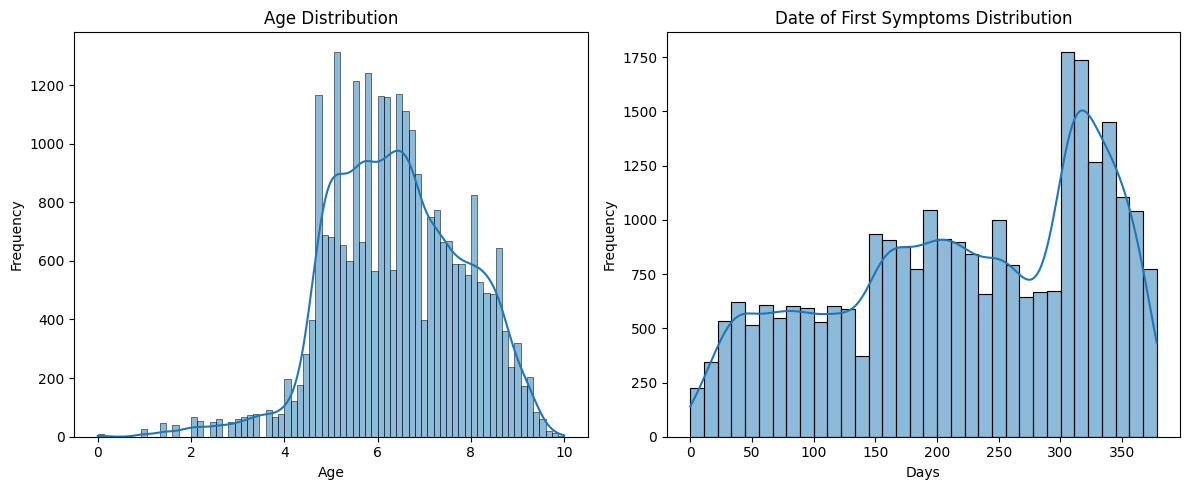

In [52]:


import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'final_df' is your DataFrame and it contains 'age' and 'date_of_first_symptoms' columns.
# Also assuming that 'age' is numerical and 'date_of_first_symptoms' is numerical (days since minimum date)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(np.sqrt(df['age']), kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['date_of_first_symptoms'], kde=True)
plt.title('Date of First Symptoms Distribution')
plt.xlabel('Days')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [48]:
min(df['age'])

-1.0

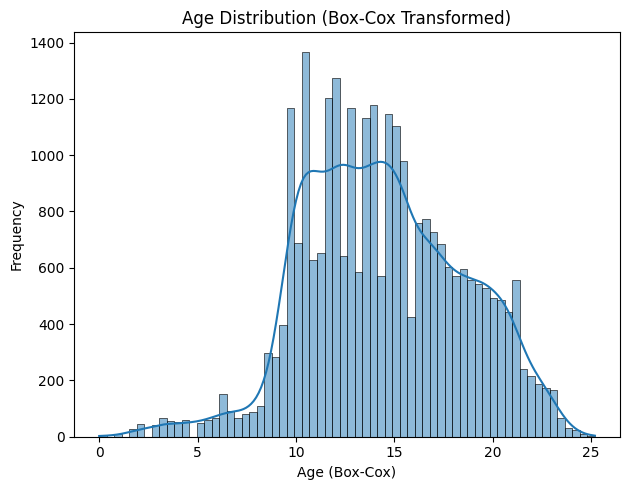

In [53]:

from scipy.stats import boxcox
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it contains 'age' and 'date_of_first_symptoms' columns.
# Also assuming that 'age' and 'date_of_first_symptoms' are numerical

# Apply Box-Cox transformation to 'age'
df['age_boxcox'], maxlog = boxcox(df['age'] + 2)  # Adding 1 to handle zero values


# Apply Box-Cox transformation to 'date_of_first_symptoms'
df['date_of_first_symptoms_boxcox'], maxlog = boxcox(df['date_of_first_symptoms'] + 1) # Adding 1 to handle zero values

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['age_boxcox'], kde=True)
plt.title('Age Distribution (Box-Cox Transformed)')
plt.xlabel('Age (Box-Cox)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

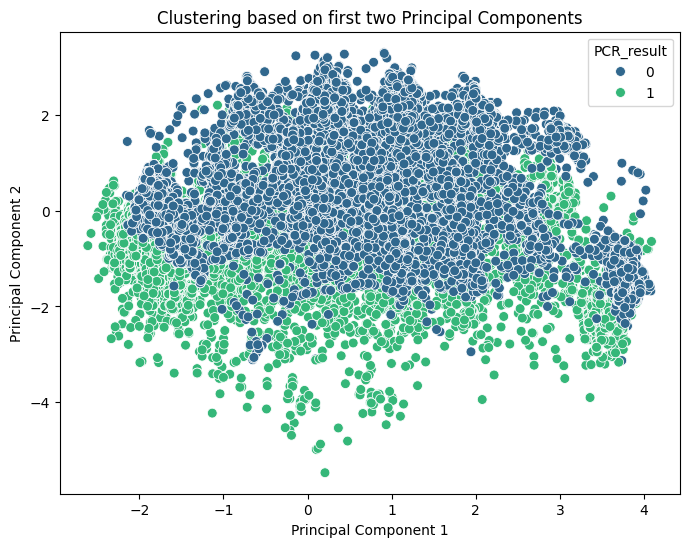

In [57]:
# prompt: Make a clustering graph based on the first two PCA, of the variables in data, and plot each depending on the value of PCR_result. Take only numeric data

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Assuming 'final_df' is your DataFrame and you want to cluster based on the first two principal components.
# 'PCR_result' is the column representing your PCR result.


# Select only numerical features for PCA
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
X = data[numeric_cols]


# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['PCR_result'] = final_df['PCR_result']

# Plot the clusters colored by 'PCR_result'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='PCR_result', data=pca_df, palette='viridis', s=50)
plt.title('Clustering based on first two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()